# 핸즈온
# CH4 모델 훈련

## 4.1 선형 회귀

선형 회귀 모델
- 식 4-1 선형 회귀 모델의 예측

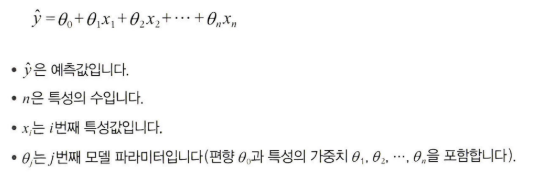

- 식 4-2 선형 회귀 모델의 예측 (벡터 형태)

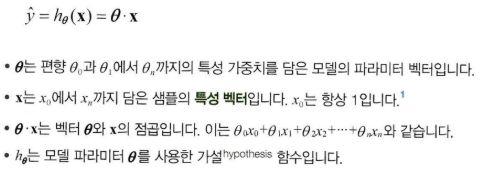

모델 훈련
- 모델 훈련 : 모델이 훈련 세트에 가장 잘 맞도록 모델 파라미터를 설정하는 것

모델의 성능 측정
- RMSE(평균 제곱근 오차)를 최소화하는 theta 값을 찾기
- MSE(평균 제곱 오차) 최소화하는 것이 같은 결과를 내면서 더 간단함

- 선형 회귀 모델의 MSE 비용 함수

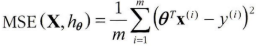

### 4.1.1 정규방정식

정규방정식
- 비용함수를 최소화하는 theta 값을 찾기 위한 해석적인 방법
- 결과를 얻을 수 있는 수학 공식

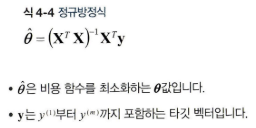

In [1]:
import numpy as np

# 무작위로 생성한 선형 데이터 셋
X = 2*np.random.randn(100,1)
y = 4 + 3*X + np.random.randn(100,1)

In [2]:
X_b = np.c_[np.ones((100,1)), X] # 모든 샘플에 x0 = 1을 추가
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [3]:
theta_best

array([[4.04126839],
       [2.99982163]])

-> theta_0 = 4, theta_1 = 3 을 기대했으나 잡음 때문에 정확히 구현하지 못함

theta_hat 을 이용해 예측하기

In [4]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.04126839],
       [10.04091165]])

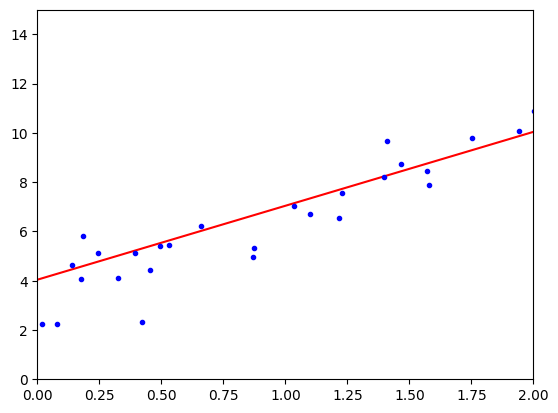

In [5]:
import matplotlib.pyplot as plt

# 선형 회귀 모델 예측
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, 'b.')
plt.axis([0,2,0,15])
plt.show()

In [6]:
# 사이킷런에서 선형 회귀 수행

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)

lin_reg.intercept_, lin_reg.coef_

(array([4.04126839]), array([[2.99982163]]))

In [7]:
lin_reg.predict(X_new)

array([[ 4.04126839],
       [10.04091165]])

LinearRegression 클래스 : scipy.linalg.lstsq() 함수를 기반으로 함

In [8]:
# scipy.linalg.lstsq() 함수 직접 호출하기
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y) # , rcond=le-6
theta_best_svd

<ipython-input-8-082b3e4c88e7>:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y) # , rcond=le-6


array([[4.04126839],
       [2.99982163]])

-> 이 함수는 theta_hat 을 계산함

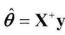

-> 여기서 X+ : X의 유사역행렬 (무어-펜로즈 역행렬)

In [9]:
# 유사역행렬 직접 구하기
np.linalg.pinv(X_b).dot(y)

array([[4.04126839],
       [2.99982163]])

유사역행렬은 특잇값 분해(SVD 표준 행렬 분해 기법)을 사용해 계산됨

### 4.1.2 계산 복잡도

- 정규 방정식은 XT @ X ((n+1)x(n+1)) 의 역행렬을 계산
- 역행렬 계산의 계산 복잡도 : O(n^2.4) 에서 O(n^3) 사이 = 특성 수가 2배 늘어나면 계산 시간이 5.3~8배로 증가함
 - O(n^2.4) == 2^2.4 = 5.3
 - O(n^3) == 2^3 = 8

- 사이킷런의 LinearRegression 클래스가 사용하는 SVD 방법 : O(n^2)
 - 특성 수가 2배로 늘어나면 계산 시간이 4배로 증가함

## 4.2 경사 하강법

경사 하강법(GD) : 여러 종류의 문제에서 최적의 해법을 찾을 수 있는 일반적인 최적화 알고리즘
- 비용 함수를 최소화하기 위해 반복해서 파라미터를 조정하는 것
- theta를 임의의 값으로 시작 (무작위 초기화)

  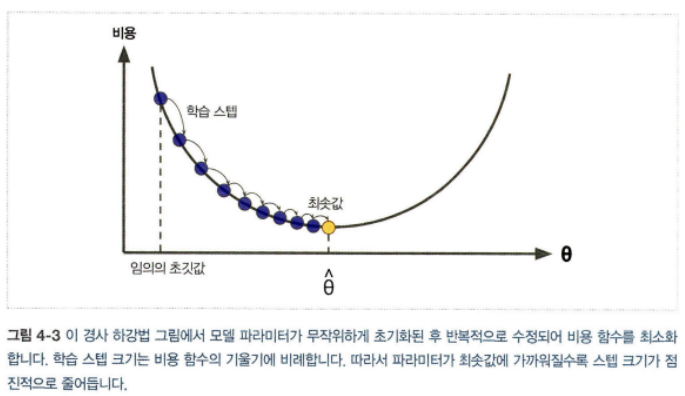

- 학습률 : 스텝의 크기
 - 학습률이 너무 작을 때 : 반복을 많이 진행해야 해서 시간이 오래 걸림
 - 학습률이 너무 클 때 : 알고리즘을 더 큰 값으로 발산하게 만들어 적절한 해법을 찾지 못함

경사 하강법의 문제접

1. 왼쪽에서 시작할 때 : 전역 최솟값보다 덜 좋은 지역 최솟값에 수렴
2. 오른쪽에서 시작할 때 : 시간이 오래 걸리고 일찍 멈추어 전역 최솟값에 도달 못 함

 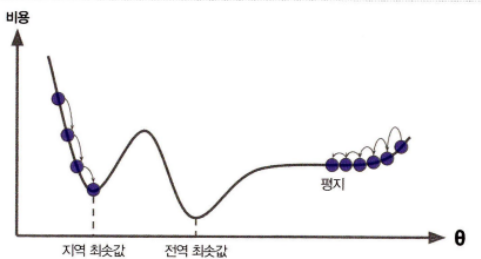

선형 회귀를 위한 MSE 비용 함수 : 볼록 함수 (지역 최솟값이 없고 하나의 전역 최솟값만 가짐)

- 모델의 파라미터 공간에서 찾는다 = 비용 함수를 최소화하는 모델 파라미터의 조합을 찾는 일

  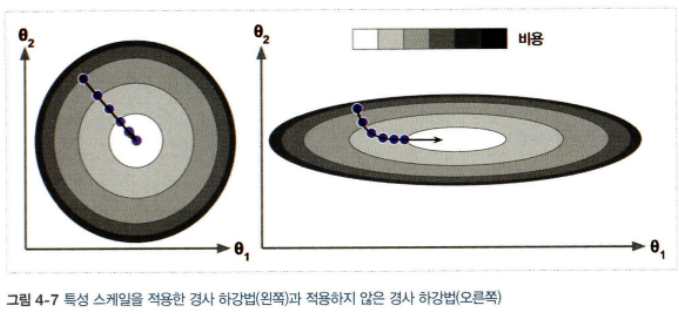

### 4.2.1 배치 경사 하강법
편도함수 : theta에 대해 비용 함수의 그레이디언트를 계산하기
- theta가 조금 변경될 때 비용 함수가 얼마나 바뀌는지 계산하기
- 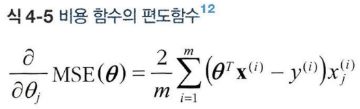

- 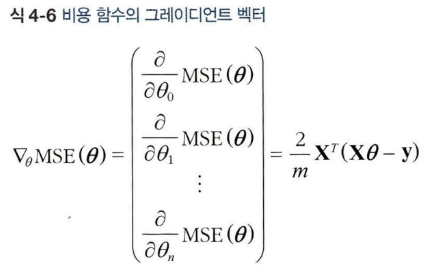

경사하강법 스텝
- 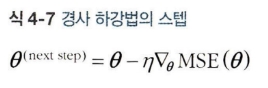

In [10]:
# 경사하강법 스텝 알고리즘 구현

eta = 0.1 #학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # 무작위 초기화

for iteration in range(n_iterations) :
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [11]:
theta

array([[4.04126839],
       [2.99982163]])

-> 정규방정식으로 찾은 것과 동일함

학습율(eta)에 따른 경사 하강법

 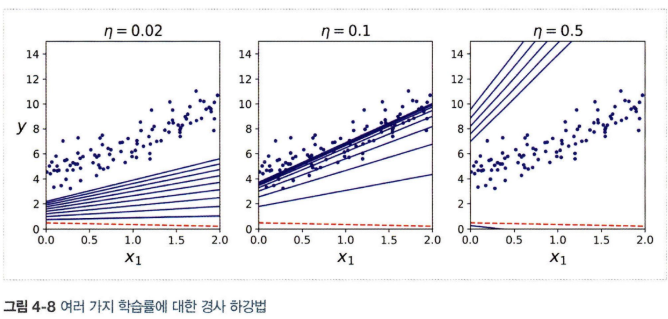

반복 횟수
- 반복 횟수를 아주 크게 지정, 그레이디언트 벡터가 아주 작아지면(허용오차보다 작어지면), 경사 하강법이 최솟값에 도달한 것임 -> 알고리즘 중지하기

### 4.2.2 확률적 경사 하강법

확률적 경사 하강법 : 매 스텝에서 한 개의 샘플을 무작위로 선택, 하나의 샘플에 대한 그레이디언트를 계산
- 장점
 - 속도가 훨씬 빠름
 - 매 반복에서 하나의 샘플만 메모리에 있으면 됨 -> 매우 큰 훈련 세트 훈련 가능

- 단점
 - 훨씬 불안정
 - 비용 함수가 최솟값에 다다를 때까지 부드럽게 감소하지 않고 위아래로 요동치면서 평균적으로 감소함

- 무작위성의 해결법
 - 학습률을 점진적으로 감소시키기 (담금질 기법)
 - 학습 스케줄 : 매 반복에서 학습률을 결정하는 함수

In [12]:
n_epochs = 50
t0, t1 = 5, 50 # 학습 스케줄 하이퍼파라미터

def learning_schedule(t) :
    return t0 / (t + t1)

theta = np.random.randn(2,1) # 무작위 초기화

for epoch in range(n_epochs):
    for i in range(m) :
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch*m+i)
        theta = theta - eta * gradients

In [13]:
theta

array([[4.02955822],
       [3.07337273]])

사이킷런에서 SGD 방식으로 선형 회귀 사용
- 기본값으로 제곱 오차 비용 함수를 최적화하는 SGDRegressor 클래스 사용

In [17]:
# 사이킷런의 SGDRegressor 모듈로 구현
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

sgd_reg.intercept_, sgd_reg.coef_

(array([4.03034979]), array([3.0069178]))

### 4.2.3 미니배치 경사 하강법

미니배치 경사 하강법
- 미니배치 (임의의 작은 샘플 세트)에 대해 그래디언트를 계산

 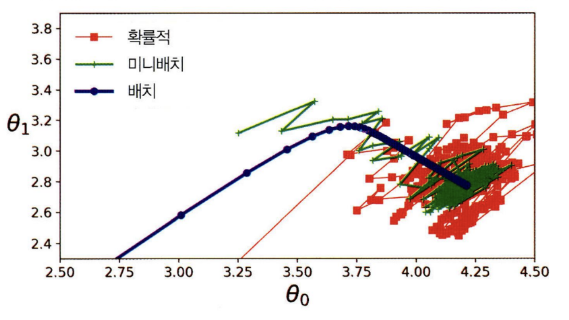

[ 선형 회귀를 상요한 알고리즘 비교 ]

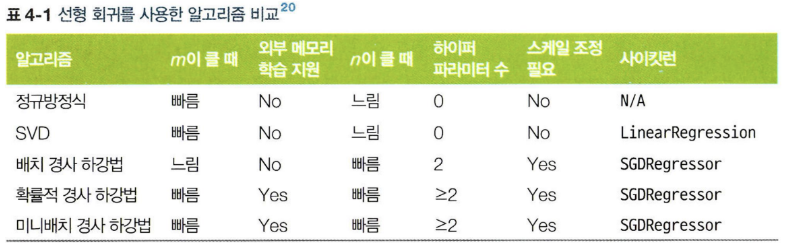

## 4.3 다항 회귀

다항 회귀 : 각 특성의 거듭제곱을 새로운 특성으로 추가, 확장된 특성을 포함한 데이터셋에 선형 모델을 훈련시키는 것

- 예시 : 2차 방정식으로 비선형 데이터를 생성

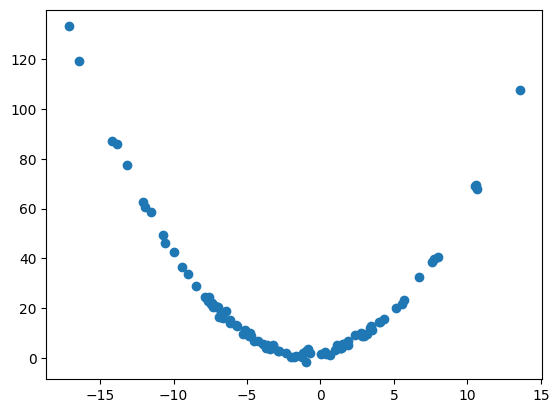

In [23]:
# 2차 방정식 비선형 데이터
m = 100
X = 6*np.random.randn(m,1) -3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)

plt.scatter(X,y)

In [19]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([2.65671794])

In [20]:
X_poly[0]

array([2.65671794, 7.05815021])

In [21]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.99315836]), array([[1.01939922, 0.50081523]]))

## 4.4 학습 곡선

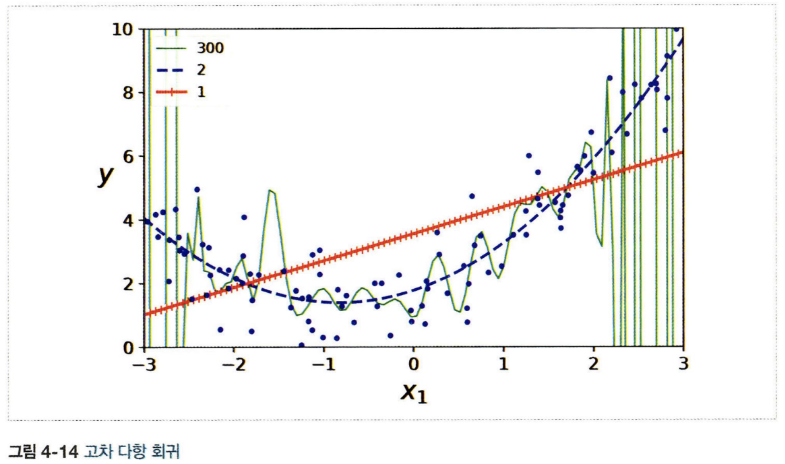

- 위 고차 다항 회귀 모델 : 훈련 데이터에 과대적합됨
- 선형 모델 : 과소 적합
- 가장 일반화가 잘 될 모델 : 2차 다항 회귀

모델의 일반화 성능을 추정하는 방법 : 학습 곡선 살펴보기

In [24]:

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model,X,y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label='train set')
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label='validation set')
    plt.legend()

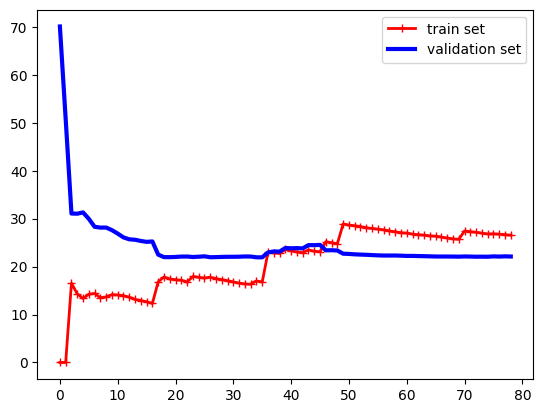

In [25]:
# 단순 선형 회귀 모델의 학습 곡선
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

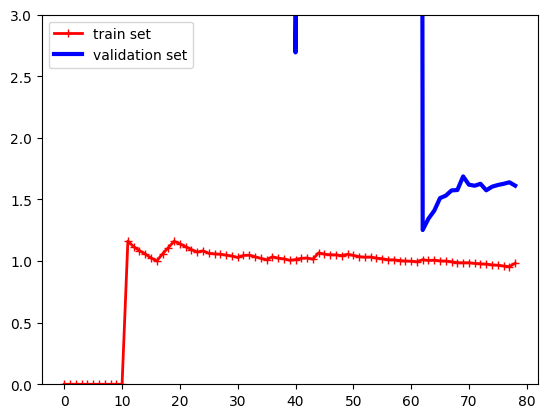

In [26]:
# 10차 다항 회귀모델의 학습 곡선
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
                                  ('lin_reg',LinearRegression())])

plt.ylim(0,3)
plot_learning_curves(polynomial_regression, X, y)
